# Node Classification with Graph Neural Networks

In this project, I will be implementing a GNN model to classify nodes in the Amazon Computers dataset. The Amazon Computers dataset was first introduced in [Shchur et al., 2019](https://arxiv.org/abs/1811.05868) titled <i>Pitfalls of Graph Neural Network Evaluation</i>. The dataset is a segment of the Amazon co-purchase graph [McAuley et al., 2015](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf), where nodes represent goods, edges indicate that two goods are frequently bought together, node features are bag-of-words encoded product reviews, and class labels are given by the product category.

First, I try a simple MLP model with 3 Linear Layers, which uses only feature embeddings to predict class labels. The model continues to train until around 150 epochs where it begins overfitting. At this point, the ROC AUC is roughly 0.55. Then I try a GNN model with 3 GCNConv Layers. The model continues to train until around 1,500 epochs before it tarts overfitting and achieves a ROC AUC of around 0.76. The difference in model performance shows that the model was able to take advantage of the available information in the edge features, which allowed it to train for longer without overfitting and achieve much better performance.

In [1]:
from torch_geometric.datasets import Amazon
from torch_geometric.transforms import NormalizeFeatures
import numpy as np
import random
import torch
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

In [2]:
dataset = Amazon(root='data/Amazon',name='computers', transform=NormalizeFeatures())

In [3]:
print()
print(f'Dataset: {dataset}')
print('===========')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset.data
# this dataset is not split into a training and a test set, so I randomly split the dataset into 20% train and 80% test
# setting the random seed so that the train and test set are always the same
random.seed(0)
data.train_mask = torch.tensor([False if random.random() < 0.8 else True for num in range(data.num_nodes)])
data.test_mask = torch.tensor([False if num == True else True for num in data.train_mask])

print()
print(data)
print('===========')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: AmazonComputers()
Number of graphs: 1
Number of features: 767
Number of classes: 10

Data(x=[13752, 767], edge_index=[2, 491722], y=[13752], train_mask=[13752], test_mask=[13752])
Number of nodes: 13752
Number of edges: 491722
Average node degree: 35.76
Number of training nodes: 2712
Training node label rate: 0.20
Has isolated nodes: True
Has self-loops: False
Is undirected: True


Above, I can see that there are 13,752 nodes and 491,722 edges which results in an average node degree of 35.8. The graph is undirected and isolated nodes do exist. I split my data into a 20% training set and an 80% test set.

Also, I made use of data transformations via transform=NormalizeFeatures(). This resulted in row-normalizing the input feature vectors. In other words, the features in each row sum up to 1.

In [4]:
# the training mask is boolean True/False
data.train_mask

tensor([ True, False, False,  ...,  True, False,  True])

In [5]:
values, counts = np.unique(data.y[data.train_mask].numpy(), return_counts=True)
print("value\tcount")
for val, count in zip(values, counts):
    print(f"{val}\t{count}")

value	count
0	81
1	433
2	278
3	102
4	1030
5	67
6	97
7	140
8	416
9	68


In [6]:
print(f"Percentage of label '4' in the full dataset: {round(counts[4]/sum(counts),2)}")
print(f"Percentage of top 3 most common labels in the full dataset: {round((counts[1]+counts[4]+counts[8])/sum(counts),2)}")

Percentage of label '4' in the full dataset: 0.38
Percentage of top 3 most common labels in the full dataset: 0.69


Here I can see that the most common value by far is 4, consisting of 38% of the dataset. This is an unbalanced classification task, so I'm going to use a different metric to evaluate performance other than accuracy. I'm going to use the AUC ROC metric. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is.

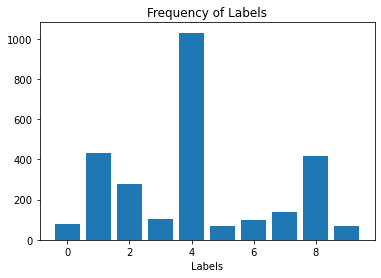

In [7]:
import matplotlib.pyplot as plt
plt.bar(height=counts, x=values)
plt.title("Frequency of Labels")
plt.xlabel("Labels")
plt.show()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
# move data to gpu for gpu acceleration
data = data.to(device)
data.is_cuda

True

## Training a Multi-layer Perceptron Network (MLP)
Here, I am going to try to infer the category of each node based solely on its feature vector, without taking any relational information into account.

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, dataset.num_classes)
        
    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return x
    
model = MLP(hidden_channels=16)
# add device to gpu for gpu acceleration
model.to(device)
print(model)

MLP(
  (lin1): Linear(in_features=767, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=10, bias=True)
)


In [11]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss
    
def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    roc_auc = roc_auc_score(lb.transform(data.y[data.test_mask].cpu()),lb.transform(pred[data.test_mask].cpu()), multi_class='ovo')
    return test_acc, roc_auc
    
# to calculate roc_auc, the data needs to be one hot encoded, which I am doing using LabelBinarizer()
lb = preprocessing.LabelBinarizer()
lb.fit(data.y[data.train_mask].cpu())

epoch_list = list()
loss_list = list()
acc_list = list()
roc_list = list()
for epoch in range(1, 1501):
    loss = train()
    if epoch%5==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    epoch_list.append(epoch)
    loss_list.append(loss.cpu().detach().numpy())
    # calculate test set accuracy
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc_list.append(test_acc)
    roc_auc = roc_auc_score(lb.transform(data.y[data.test_mask].cpu()),lb.transform(pred[data.test_mask].cpu()), multi_class='ovo')
    roc_list.append(roc_auc)

Epoch: 005, Loss: 2.2087
Epoch: 010, Loss: 2.0906
Epoch: 015, Loss: 1.9735
Epoch: 020, Loss: 1.9523
Epoch: 025, Loss: 1.9034
Epoch: 030, Loss: 1.8977
Epoch: 035, Loss: 1.8737
Epoch: 040, Loss: 1.8668
Epoch: 045, Loss: 1.8490
Epoch: 050, Loss: 1.8242
Epoch: 055, Loss: 1.7988
Epoch: 060, Loss: 1.7678
Epoch: 065, Loss: 1.7358
Epoch: 070, Loss: 1.6913
Epoch: 075, Loss: 1.6510
Epoch: 080, Loss: 1.6199
Epoch: 085, Loss: 1.6002
Epoch: 090, Loss: 1.5763
Epoch: 095, Loss: 1.5495
Epoch: 100, Loss: 1.5399
Epoch: 105, Loss: 1.5173
Epoch: 110, Loss: 1.4988
Epoch: 115, Loss: 1.4979
Epoch: 120, Loss: 1.4768
Epoch: 125, Loss: 1.4715
Epoch: 130, Loss: 1.4537
Epoch: 135, Loss: 1.4453
Epoch: 140, Loss: 1.4318
Epoch: 145, Loss: 1.4291
Epoch: 150, Loss: 1.4223
Epoch: 155, Loss: 1.4240
Epoch: 160, Loss: 1.4050
Epoch: 165, Loss: 1.3994
Epoch: 170, Loss: 1.4034
Epoch: 175, Loss: 1.3996
Epoch: 180, Loss: 1.3893
Epoch: 185, Loss: 1.3762
Epoch: 190, Loss: 1.3761
Epoch: 195, Loss: 1.3676
Epoch: 200, Loss: 1.3619


After training the model, I call the `test` function to see how well the model performs. I also write the `test` function to output the ROC AUC since the classes are unbalanced. I can see the performance is pretty poor when using just the feature vectors. A big reason for this is that connected products are very likely related to the category of the product. This is where Graph Neural Networks can potentially boost the performance of the model.

Below, I can see that within about 150 epochs, the ROC AUC levels off and the model begins overfitting. The model begins overfitting much faster here than with the GNN since there is less data to work from, since the model does not have access to the links between the nodes and is only making predictions based on the feature vectors.

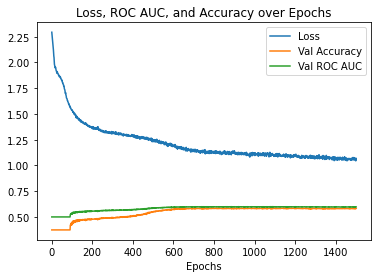

In [12]:
plt.plot(epoch_list, loss_list, label= "Loss")
plt.plot(epoch_list, acc_list, label = "Val Accuracy")
plt.plot(epoch_list, roc_list, label = "Val ROC AUC")
plt.title("Loss, ROC AUC, and Accuracy over Epochs")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [13]:
print(f'Val Accuracy last epoch: {acc_list[-1]:.4f}')
print(f'Val ROC AUC last epoch: {roc_list[-1]:.4f}')
print()
print(f'Val Accuracy at epoch 150: {acc_list[150]:.4f}')
print(f'Val ROC AUC epoch 150: {roc_list[150]:.4f}')

Val Accuracy last epoch: 0.5824
Val ROC AUC last epoch: 0.5974

Val Accuracy at epoch 150: 0.4736
Val ROC AUC epoch 150: 0.5526


In [14]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(767, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 10)
)


In [15]:
model = GCN(hidden_channels=16)
# move model to gpu
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    roc_auc = roc_auc_score(lb.transform(data.y[data.test_mask].cpu()),lb.transform(pred[data.test_mask].cpu()), multi_class='ovo')
    return test_acc, roc_auc


# to calculate roc_auc, the data needs to be one hot encoded, which I am doing using LabelBinarizer()
lb = preprocessing.LabelBinarizer()
lb.fit(data.y[data.train_mask].cpu())
    
epoch_list = list()
loss_list = list()
acc_list = list()
roc_list = list()
for epoch in range(1, 3001):
    loss = train()
    if epoch%10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    epoch_list.append(epoch)
    loss_list.append(loss.cpu().detach().numpy())
    # calculate test set accuracy
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc_list.append(test_acc)
    roc_auc = roc_auc_score(lb.transform(data.y[data.test_mask].cpu()),lb.transform(pred[data.test_mask].cpu()), multi_class='ovo')
    roc_list.append(roc_auc)

Epoch: 010, Loss: 2.1369
Epoch: 020, Loss: 1.9447
Epoch: 030, Loss: 1.9192
Epoch: 040, Loss: 1.9100
Epoch: 050, Loss: 1.8943
Epoch: 060, Loss: 1.8978
Epoch: 070, Loss: 1.8748
Epoch: 080, Loss: 1.8500
Epoch: 090, Loss: 1.7913
Epoch: 100, Loss: 1.7113
Epoch: 110, Loss: 1.6241
Epoch: 120, Loss: 1.5681
Epoch: 130, Loss: 1.5375
Epoch: 140, Loss: 1.5001
Epoch: 150, Loss: 1.4739
Epoch: 160, Loss: 1.4460
Epoch: 170, Loss: 1.4144
Epoch: 180, Loss: 1.4015
Epoch: 190, Loss: 1.3775
Epoch: 200, Loss: 1.3749
Epoch: 210, Loss: 1.3486
Epoch: 220, Loss: 1.3424
Epoch: 230, Loss: 1.3309
Epoch: 240, Loss: 1.3032
Epoch: 250, Loss: 1.3098
Epoch: 260, Loss: 1.2909
Epoch: 270, Loss: 1.2950
Epoch: 280, Loss: 1.2939
Epoch: 290, Loss: 1.2682
Epoch: 300, Loss: 1.2685
Epoch: 310, Loss: 1.2729
Epoch: 320, Loss: 1.2708
Epoch: 330, Loss: 1.2483
Epoch: 340, Loss: 1.2471
Epoch: 350, Loss: 1.2603
Epoch: 360, Loss: 1.2632
Epoch: 370, Loss: 1.2561
Epoch: 380, Loss: 1.2346
Epoch: 390, Loss: 1.2385
Epoch: 400, Loss: 1.2508


Below I can see that with the GNN, the model ROC AUC continues to increase for far longer than with the MLP model. It is able to utilize much more data since it has access to the edges and it is able to use that information to achieve a much higher accuracy score. The performance of the GNN doesn't level off until around epoch 1500.

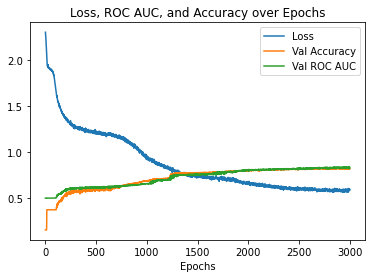

In [16]:
plt.plot(epoch_list, loss_list, label= "Loss")
plt.plot(epoch_list, acc_list, label = "Val Accuracy")
plt.plot(epoch_list, roc_list, label = "Val ROC AUC")
plt.title("Loss, ROC AUC, and Accuracy over Epochs")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [17]:
print(f'Val Accuracy last epoch: {acc_list[-1]:.4f}')
print(f'Val ROC AUC last epoch: {roc_list[-1]:.4f}')
print()
print(f'Val Accuracy at epoch 1500: {acc_list[1500]:.4f}')
print(f'Val ROC AUC epoch 1500: {roc_list[1500]:.4f}')

Val Accuracy last epoch: 0.8237
Val ROC AUC last epoch: 0.8341

Val Accuracy at epoch 1500: 0.7763
Val ROC AUC epoch 1500: 0.7596
